In [61]:
# https://chatgpt.com/share/677ea92d-b844-8009-91d1-932799305a61

### Importazione librerie

In [62]:
import pandas as pd
import numpy as np
import ccxt
import time
import matplotlib.pyplot as plt
import random

### Download dati

In [63]:
def download_and_plot(cryptos, timeframe_download, start_date, end_date, plot):
    
    exchange = ccxt.binance()  # Usa Binance come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [64]:
initial_allocations = {'BTC': 1/6, 'ETH': 5/6}

In [65]:
# cryptos = list(initial_allocations.keys())  # Specifica le crypto
# timeframe_download = '1m'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
# start_date = '2021-01-01'  # Data di inizio
# end_date = '2021-12-31'  # Data di fine
# plot = False

# data_frames = download_and_plot(cryptos, timeframe_download, start_date, end_date, plot)
# crypto_prices = pd.DataFrame()
# crypto_prices['timestamp'] = data_frames[cryptos[0]].index
# for crypto in cryptos:
#     crypto_prices[crypto] = data_frames[crypto]['close'].values
# crypto_prices.set_index('timestamp', inplace=True)
# crypto_prices

In [66]:
# crypto_prices.to_csv("['BTC', 'ETH']_USDT_timeframe_1m_start_date_2021-01-01_end_date_2021-12-31.csv")

In [67]:
crypto_prices = pd.read_csv("['BTC', 'ETH']_USDT_timeframe_1m_start_date_2021-01-01_end_date_2021-12-31.csv")
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices

,BTC,ETH
timestamp,,
2021-01-01 00:00:00,28961.66,737.02
2021-01-01 00:01:00,29009.91,738.74
2021-01-01 00:02:00,28989.30,737.82
2021-01-01 00:03:00,28982.69,737.43
2021-01-01 00:04:00,28975.65,736.89
...,...,...
2021-12-30 23:56:00,47134.56,3708.88
2021-12-30 23:57:00,47144.56,3710.99
2021-12-30 23:58:00,47139.98,3710.88


In [68]:
crypto_prices = crypto_prices[:1*1440]

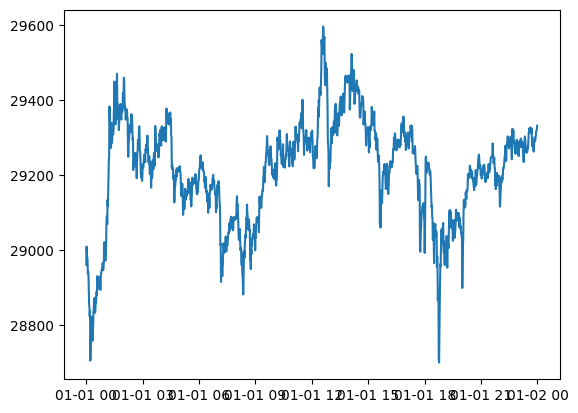

In [69]:
plt.plot(crypto_prices.index, crypto_prices['BTC'])

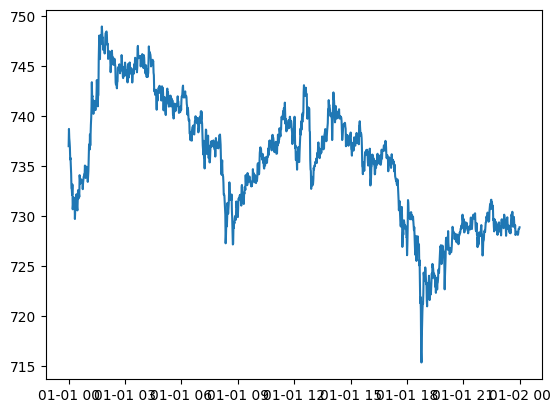

In [70]:
plt.plot(crypto_prices.index, crypto_prices['ETH'])

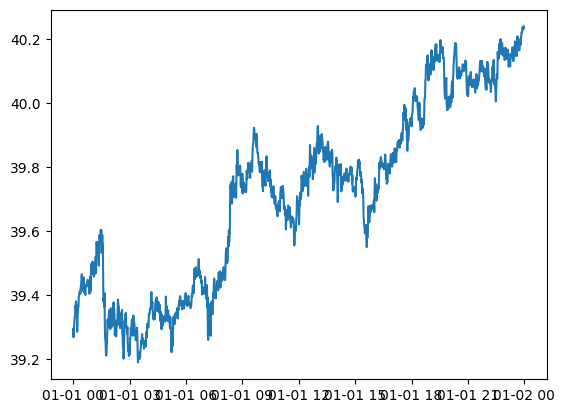

In [71]:
plt.plot(crypto_prices.index, crypto_prices['BTC'] / crypto_prices['ETH'])

### Strategia

In [72]:
# Funzione per calcolare i minimi e massimi locali
def find_local_extrema(series: pd.Series):
    """
    Trova i minimi e i massimi locali in una serie temporale.
    Ritorna due Series booleane della stessa lunghezza di 'series':
    - minima[i] = True se 'series[i]' è un minimo locale
    - maxima[i] = True se 'series[i]' è un massimo locale
    """
    minima = (series < series.shift(1)) & (series < series.shift(-1))
    maxima = (series > series.shift(1)) & (series > series.shift(-1))
    return minima, maxima

In [73]:
# Funzione che mappa la variazione percentuale alla percentuale da vendere
def map_sell_percentage(price_change_percentage: float) -> float:
    """
    Esempio di funzione di mappatura.
    Limita la percentuale di vendita tra 0% e 100%.
    """
    return max(0, min(1, price_change_percentage))

In [74]:
def backtest_strategy(
    crypto_prices: pd.DataFrame,
    initial_cash: float,
    initial_allocations: dict,
    timeframe: int,
    window: int,
    perc_sell_ETH_BTC: float,
    perc_sell_BTC_ETH: float,
    include_liquidity: bool,
    # Nuovi parametri per la logica "trend del portafoglio"
    portfolio_ma_window: int,
    perc_sell_on_portfolio_drop: float,
    perc_buy_on_portfolio_rise: float,
    alloc_buy_BTC: float,
    alloc_buy_ETH: float
) -> pd.DataFrame:
    """
    Backtest della strategia di rotazione del capitale.

    Parametri:
    -----------
    crypto_prices : DataFrame con colonne 'BTC' e 'ETH' e indice temporale.
    initial_cash : liquidità iniziale disponibile.
    initial_allocations : es. {'BTC': 0.2, 'ETH': 0.7}.
    timeframe : ogni quanti "punti" temporalmente distanziati avviene il ribilanciamento.
    window : finestra per il calcolo della media mobile del rapporto BTC/ETH.
    perc_sell_ETH_BTC : percentuale con cui ricomprare BTC (se si vende ETH).
    perc_sell_BTC_ETH : percentuale con cui ricomprare ETH (se si vende BTC).
    include_liquidity : se True la percentuale di acquisto si calcola su (cash + ricavato vendita).
    portfolio_ma_window : finestra per calcolare la media mobile del portafoglio.
    perc_sell_on_portfolio_drop: percentuale di TUTTI i token da vendere se il portafoglio < media mobile.
    perc_buy_on_portfolio_rise : percentuale di liquidità da investire se il portafoglio > media mobile.
    alloc_buy_BTC : percentuale da destinare a BTC quando si compra con la liquidità (0 < alloc_buy_BTC < 1).
    alloc_buy_ETH : percentuale da destinare a ETH (alloc_buy_BTC + alloc_buy_ETH = 1).

    Ritorna:
    -----------
    df_transactions : DataFrame, contenente le informazioni giornaliere:
        - Data/Index
        - Prezzi BTC/ETH
        - Ratio e Ratio Moving Avg
        - Azione del giorno (se nessuna operazione, '-')
        - Ultima azione != '-'
        - Holdings di BTC/ETH
        - Liquidità residua
        - Valore totale di portafoglio
        - Eventuali altre colonne utili (ultimo estremo, valore ultimo estremo, etc.)
    """

    # Copia locale dei prezzi per non modificare l'originale
    prices = crypto_prices.copy()

    # Calcolo del rapporto BTC/ETH e della sua media mobile
    prices['BTC_ETH_ratio'] = prices['BTC'] / prices['ETH']
    prices['ratio_moving_avg'] = prices['BTC_ETH_ratio'].rolling(window=window).mean()

    # Trova minimi e massimi locali sulla media mobile del rapporto
    minima, maxima = find_local_extrema(prices['ratio_moving_avg'])

    # Inizializzazioni
    cash = initial_cash
    btc_holdings = (cash * initial_allocations.get('BTC', 0.0)) / prices['BTC'].iloc[0]
    eth_holdings = (cash * initial_allocations.get('ETH', 0.0)) / prices['ETH'].iloc[0]
    cash_residual = cash * (1 - sum(initial_allocations.values()))

    # Variabili per tracciare l’ultimo estremo
    last_extreme = None   # 'min' o 'max'
    last_extreme_value = None

    # Per tracciare l'ultima azione != "-"
    last_non_empty_action = "-"

    # Lista per costruire il DataFrame finale
    records = []

    # Qui accumuliamo i valori di portafoglio, in modo da calcolare la media mobile
    # del portafoglio a posteriori (intra-loop).
    portfolio_values = []

    # Iteriamo su ogni giorno (o barra temporale) del dataframe
    for i in range(len(prices)):

        date_index = prices.index[i]  # Timestamp
        btc_price = prices['BTC'].iloc[i]
        eth_price = prices['ETH'].iloc[i]
        ratio = prices['BTC_ETH_ratio'].iloc[i]
        ratio_ma = prices['ratio_moving_avg'].iloc[i]

        # 1) Calcola il valore attuale di portafoglio (prima di fare la strategia odierna)
        total_portfolio_value = (
            btc_holdings * btc_price +
            eth_holdings * eth_price +
            cash_residual
        )

        # 2) Salva il valore (ci servirà per calcolare la media mobile)
        portfolio_values.append(total_portfolio_value)

        # 3) Logica di rotazione basata su BTC_ETH_ratio e min/max locali
        if i < window - 1 or pd.isna(ratio_ma):
            # Non possiamo ancora attuare la strategia perché la ratio_moving_avg non è disponibile
            current_action = "-"
        else:
            # Verifichiamo se è un giorno di ribilanciamento
            if (i % timeframe) == 0:
                # Aggiorniamo l'ultimo estremo se c'è un minimo/massimo locale
                if minima.iloc[i]:
                    last_extreme = 'min'
                    last_extreme_value = ratio_ma
                elif maxima.iloc[i]:
                    last_extreme = 'max'
                    last_extreme_value = ratio_ma

                # Se non abbiamo un estremo definito, nessuna operazione su ratio
                if not last_extreme:
                    current_action = "-"
                else:
                    if last_extreme == 'max':
                        # Calo rispetto all'ultimo max
                        price_drop_percentage = (last_extreme_value - ratio_ma) / last_extreme_value
                        sell_ratio_pct = map_sell_percentage(price_drop_percentage)

                        # ETH da vendere
                        eth_to_sell = sell_ratio_pct * eth_holdings
                        sell_value = eth_to_sell * eth_price

                        # Aggiorna holdings di ETH
                        eth_holdings -= eth_to_sell

                        # Calcolo quanto BTC comprare
                        if include_liquidity:
                            total_liquidity = cash_residual + sell_value
                            buy_value = total_liquidity * perc_sell_ETH_BTC
                            cash_residual = total_liquidity - buy_value
                        else:
                            buy_value = sell_value * perc_sell_ETH_BTC
                            cash_residual += (sell_value - buy_value)

                        btc_bought = buy_value / btc_price
                        btc_holdings += btc_bought

                        current_action = "sell ETH, buy BTC" if eth_to_sell > 0 else "-"

                    elif last_extreme == 'min':
                        # Aumento rispetto all'ultimo min
                        price_rise_percentage = (ratio_ma - last_extreme_value) / last_extreme_value
                        sell_ratio_pct = map_sell_percentage(price_rise_percentage)

                        # BTC da vendere
                        btc_to_sell = sell_ratio_pct * btc_holdings
                        sell_value = btc_to_sell * btc_price

                        # Aggiorna holdings di BTC
                        btc_holdings -= btc_to_sell

                        # Calcolo quanto ETH comprare
                        if include_liquidity:
                            total_liquidity = cash_residual + sell_value
                            buy_value = total_liquidity * perc_sell_BTC_ETH
                            cash_residual = total_liquidity - buy_value
                        else:
                            buy_value = sell_value * perc_sell_BTC_ETH
                            cash_residual += (sell_value - buy_value)

                        eth_bought = buy_value / eth_price
                        eth_holdings += eth_bought

                        current_action = "sell BTC, buy ETH" if btc_to_sell > 0 else "-"

                    else:
                        current_action = "-"
            else:
                current_action = "-"

        # 4) Dopo la logica del ratio, ricalcoliamo il valore del portafoglio
        total_portfolio_value = (
            btc_holdings * btc_price +
            eth_holdings * eth_price +
            cash_residual
        )

        # 5) Ora implementiamo la logica "trend del portafoglio" (MA del portafoglio)
        #    Se abbiamo abbastanza dati, calcoliamo la media mobile su portfolio_values.
        #    Utilizziamo i giorni precedenti, es: [i - portfolio_ma_window : i]
        if i >= portfolio_ma_window:
            recent_values = portfolio_values[i-portfolio_ma_window : i]
            portfolio_ma = sum(recent_values) / len(recent_values)

            # Se il portafoglio attuale è < media mobile => vendiamo una % di TUTTI i token
            # Se il portafoglio attuale è > media mobile => compriamo una % di tutta la liquidità
            if total_portfolio_value < portfolio_ma:
                # Vendo una certa percentuale di TUTTI i token
                btc_to_sell = btc_holdings * perc_sell_on_portfolio_drop
                eth_to_sell = eth_holdings * perc_sell_on_portfolio_drop

                # Incasso BTC
                sell_value_btc = btc_to_sell * btc_price
                cash_residual += sell_value_btc
                btc_holdings -= btc_to_sell

                # Incasso ETH
                sell_value_eth = eth_to_sell * eth_price
                cash_residual += sell_value_eth
                eth_holdings -= eth_to_sell

                if btc_to_sell > 0 or eth_to_sell > 0:
                    current_action += " | sell % portfolio"
            
            elif total_portfolio_value > portfolio_ma:
                # Compro con una certa percentuale di cash
                cash_to_invest = cash_residual * perc_buy_on_portfolio_rise
                if cash_to_invest > 0:
                    # Divido la spesa tra BTC e ETH
                    buy_btc = cash_to_invest * alloc_buy_BTC
                    buy_eth = cash_to_invest * alloc_buy_ETH

                    # Acquisto BTC
                    btc_holdings += (buy_btc / btc_price)
                    # Acquisto ETH
                    eth_holdings += (buy_eth / eth_price)

                    cash_residual -= cash_to_invest

                    current_action += " | buy % portfolio"
        
        # Se l'azione di oggi è diversa da "-", aggiorna last_non_empty_action
        if current_action != "-":
            last_non_empty_action = current_action

        # 6) Calcoliamo di nuovo il valore attuale di portafoglio dopo la nuova eventuale operazione
        total_portfolio_value = (
            btc_holdings * btc_price +
            eth_holdings * eth_price +
            cash_residual
        )

        # Salviamo i dati giornalieri nel record
        records.append({
            'Date': date_index,
            'BTC_Price': btc_price,
            'ETH_Price': eth_price,
            'BTC_ETH_Ratio': ratio,
            'Ratio_MA': ratio_ma,
            'Local_Min': (False if i < window-1 else minima.iloc[i]),
            'Local_Max': (False if i < window-1 else maxima.iloc[i]),
            'Last_Extreme_Type': last_extreme,
            'Last_Extreme_Value': last_extreme_value,
            'Action': current_action,
            'Last_Non_Empty_Action': last_non_empty_action,
            'BTC_Holdings': btc_holdings,
            'ETH_Holdings': eth_holdings,
            'Cash': cash_residual,
            'Portfolio_Value': total_portfolio_value
        })

    # Creiamo il DataFrame finale
    df_transactions = pd.DataFrame(records)
    df_transactions.set_index('Date', inplace=True)

    return df_transactions

In [88]:
initial_cash = 1000
initial_allocations={'BTC': 0.3, 'ETH': 0.4}
timeframe = 60
window = 15
perc_sell_ETH_BTC = 1
perc_sell_BTC_ETH = 1
include_liquidity = True
portfolio_ma_window = 60
perc_sell_on_portfolio_drop = 1
perc_buy_on_portfolio_rise = 0.9
alloc_buy_BTC = 0.5
alloc_buy_ETH = 0.5

df_results = backtest_strategy(
    crypto_prices,
    initial_cash,
    initial_allocations,
    timeframe,
    window,
    perc_sell_ETH_BTC,
    perc_sell_BTC_ETH,
    include_liquidity,
    # Nuovi parametri
    portfolio_ma_window,
    perc_sell_on_portfolio_drop,
    perc_buy_on_portfolio_rise,
    alloc_buy_BTC,
    alloc_buy_ETH
)

df_results

,BTC_Price,ETH_Price,BTC_ETH_Ratio,Ratio_MA,Local_Min,Local_Max,Last_Extreme_Type,Last_Extreme_Value,Action,Last_Non_Empty_Action,BTC_Holdings,ETH_Holdings,Cash,Portfolio_Value
Date,,,,,,,,,,,,,,
2021-01-01 00:00:00,28961.66,737.02,39.295623,NaN,False,False,None,NaN,-,-,0.010359,0.542726,300.000000,1000.000000
2021-01-01 00:01:00,29009.91,738.74,39.269445,NaN,False,False,None,NaN,-,-,0.010359,0.542726,300.000000,1001.433288
2021-01-01 00:02:00,28989.30,737.82,39.290477,NaN,False,False,None,NaN,-,-,0.010359,0.542726,300.000000,1000.720490
2021-01-01 00:03:00,28982.69,737.43,39.302293,NaN,False,False,None,NaN,-,-,0.010359,0.542726,300.000000,1000.440357
2021-01-01 00:04:00,28975.65,736.89,39.321541,NaN,False,False,None,NaN,-,-,0.010359,0.542726,300.000000,1000.074361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01 23:55:00,29309.60,728.38,40.239435,40.199397,False,False,min,40.08378,-,- | sell % portfolio,0.000000,0.000000,1011.730163,1011.730163
2021-01-01 23:56:00,29317.22,728.74,40.230013,40.203024,False,False,min,40.08378,-,- | sell % portfolio,0.000000,0.000000,1011.730163,1011.730163
2021-01-01 23:57:00,29319.20,728.75,40.232178,40.206519,False,False,min,40.08378,-,- | sell % portfolio,0.000000,0.000000,1011.730163,1011.730163


In [89]:
df_results['Portfolio_Value'].iloc[-1] / df_results['Portfolio_Value'].iloc[0]

1.0117301631088036

In [90]:
def plot_equity_line(df_transactions: pd.DataFrame, 
                     title: str = "Equity Line", 
                     date_col: str = None, 
                     equity_col: str = 'Portfolio_Value'):
    """
    Plotta l'equity line (Portfolio_Value) in funzione del tempo.
    Se date_col è None, si assume che l'indice del DataFrame sia già il timestamp.
    """
    plt.figure(figsize=(10, 5))
    if date_col is not None:
        # Se la colonna della data è esplicita
        plt.plot(df_transactions[date_col], df_transactions[equity_col], label='Equity')
    else:
        # Altrimenti usiamo direttamente l'indice
        plt.plot(df_transactions.index, df_transactions[equity_col], label='Equity')
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()

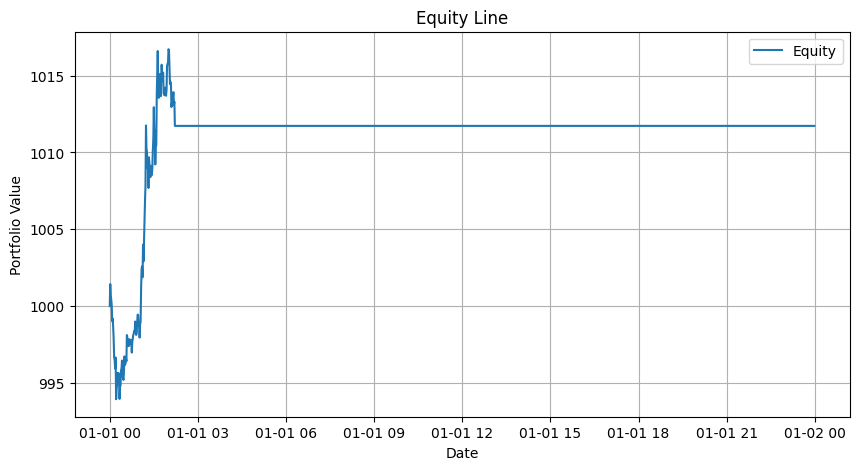

In [91]:
plot_equity_line(df_results)

### Suddivisione dei dati in train, validation e test

In [15]:
def chunk_data(df: pd.DataFrame, 
               chunk_size: int) -> list:
    """
    Suddivide il DataFrame in blocchi di dimensione chunk_size, 
    unendo l'eventuale ultimo blocco parziale a quello precedente.

    Parametri
    ----------
    df : pd.DataFrame
        DataFrame ordinato cronologicamente.
    chunk_size : int
        Numero di righe per ciascun blocco.

    Ritorna
    ----------
    chunks : list of pd.DataFrame
        Lista dei blocchi, ognuno ordinato cronologicamente.
    """
    n_rows = len(df)
    n_full_chunks = n_rows // chunk_size
    remainder = n_rows % chunk_size

    chunks = []
    start_idx = 0

    for i in range(n_full_chunks):
        end_idx = start_idx + chunk_size
        chunk = df.iloc[start_idx:end_idx]
        chunks.append(chunk)
        start_idx = end_idx

    # Se c'è un blocco parziale in coda
    if remainder > 0:
        # Unisci il blocco parziale all'ultimo chunk
        last_chunk_extended = pd.concat([chunks[-1], df.iloc[-remainder:]], axis=0)
        chunks[-1] = last_chunk_extended

    return chunks

In [16]:
def split_into_train_val_test(chunks: list, 
                              train_ratio: float, 
                              val_ratio: float, 
                              test_ratio: float, 
                              shuffle: bool = True,
                              random_state: int = None) -> tuple:
    """
    Suddivide la lista di blocchi in Train, Validation e Test 
    in base alle proporzioni specificate.

    Parametri
    ----------
    chunks : list of pd.DataFrame
        Blocchi di dati (ciascuno già ordinato cronologicamente).
    train_ratio : float
        Percentuale di blocchi da dedicare al train (0 < train_ratio < 1).
    val_ratio : float
        Percentuale di blocchi da dedicare alla validation (0 < val_ratio < 1).
    test_ratio : float
        Percentuale di blocchi da dedicare al test (0 < test_ratio < 1).
        Deve valere train_ratio + val_ratio + test_ratio = 1.
    shuffle : bool, default=True
        Se True, mescola i blocchi prima di suddividerli.
    random_state : int, default=None
        Seed per la riproducibilità.

    Ritorna
    ----------
    (train_chunks, val_chunks, test_chunks) : tuple
        Tre liste di blocchi di DataFrame, rispettivamente per train, validation e test.
    """
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-9, \
           "Le proporzioni di train, validation, test devono sommare a 1."

    n_chunks = len(chunks)

    # Shuffle opzionale
    if shuffle:
        if random_state is not None:
            random.seed(random_state)
        random.shuffle(chunks)

    # Calcolo le soglie sugli indici di chunk
    train_end = int(train_ratio * n_chunks)
    val_end = train_end + int(val_ratio * n_chunks)
    # I blocchi da val_end in poi vanno al test

    train_chunks = chunks[:train_end]
    val_chunks = chunks[train_end:val_end]
    test_chunks = chunks[val_end:]

    return train_chunks, val_chunks, test_chunks

In [17]:
def reassemble_chunks(chunks: list) -> pd.DataFrame:
    """
    Ricompone i blocchi in un unico DataFrame, 
    ri-ordinandoli cronologicamente in base all'indice.
    """
    if not chunks:
        return pd.DataFrame()  # Nessun chunk

    # Concateno e poi ordino in base all'indice (o in base alle date)
    df_merged = pd.concat(chunks, axis=0)
    df_merged.sort_index(inplace=True)
    return df_merged

In [18]:
def create_train_val_test_sets(df: pd.DataFrame,
                               chunk_size: int,
                               train_ratio: float,
                               val_ratio: float,
                               test_ratio: float,
                               shuffle_chunks: bool = True,
                               random_state: int = None) -> tuple:
    """
    Funzione principale che genera:
      - train_df
      - val_df
      - test_df

    seguendo l'algoritmo:
      1) Suddivisione in blocchi di dimensione `chunk_size`.
      2) Shuffle (opzionale).
      3) Split in train, validation, test in base alle percentuali.
      4) Ri-assemblaggio dei blocchi e ordinamento cronologico.

    Parametri
    ----------
    df : pd.DataFrame
        Dati originali (cronologicamente ordinati).
    chunk_size : int
        Numero di righe per blocco.
    train_ratio : float
        Percentuale dei blocchi da allocare al train.
    val_ratio : float
        Percentuale dei blocchi da allocare alla validation.
    test_ratio : float
        Percentuale dei blocchi da allocare al test.
    shuffle_chunks : bool, default=True
        Se True, mescola i blocchi prima di fare train/val/test split.
    random_state : int, default=None
        Seed per la riproducibilità dello shuffle.

    Ritorna
    ----------
    train_df, val_df, test_df : tuple of pd.DataFrame
        I tre set risultanti, ognuno ordinato cronologicamente al suo interno.
    """
    # 1) Chunking
    chunks = chunk_data(df, chunk_size=chunk_size)

    # 2 e 3) Split in train/val/test con shuffle opzionale
    train_chunks, val_chunks, test_chunks = split_into_train_val_test(
        chunks,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        test_ratio=test_ratio,
        shuffle=shuffle_chunks,
        random_state=random_state
    )

    # 4) Ri-assemblaggio e ordinamento cronologico
    # train_df = reassemble_chunks(train_chunks)
    # val_df = reassemble_chunks(val_chunks)
    # test_df = reassemble_chunks(test_chunks)

    return train_chunks, val_chunks, test_chunks

In [26]:
# Parametri di esempio (modifica liberamente)
CHUNK_SIZE = 1440
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SHUFFLE_CHUNKS = True
RANDOM_STATE = 42

train_chunks, val_chunks, test_chunks = create_train_val_test_sets(
    df=crypto_prices,
    chunk_size=CHUNK_SIZE,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    shuffle_chunks=SHUFFLE_CHUNKS,
    random_state=RANDOM_STATE
)

print("Numero blocchi in train:", len(train_chunks))
print("Numero dati in train:", sum(len(chunk) for chunk in train_chunks))

print("Numero blocchi in validation:", len(val_chunks))
print("Numero dati in validation:", sum(len(chunk) for chunk in val_chunks))

print("Numero blocchi in test:", len(test_chunks))
print("Numero dati in test:", sum(len(chunk) for chunk in test_chunks))

Numero blocchi in train: 254
Numero dati in train: 366208
Numero blocchi in validation: 54
Numero dati in validation: 77760
Numero blocchi in test: 55
Numero dati in test: 79200
